# Regional CRE Emergent Constraints

Notebook to investigate emergent constraints on regional cloud feedbacks

# Set things up

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as ss
import scipy.signal as ssi
#from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
def sdat(c, F):
        #My old fashioned way of saving data
        np.savez(F, u=c)
        return 0
    
def lin_regression(var1, var2):
    """
    Regresses var1 onto var2
    Returns: slope, intercept, r_value, p_value, std_err
    """
    #print "Linear regression"
    return ss.linregress(var1, var2)

def annual_mean(data):
    
    d1 = len(data)
    ndata = np.zeros( d1 // 12)
    for i in range( d1 // 12):
        ndata[i] = np.mean(data[i * 12:(i + 1) * 12])
        
    return ndata

def deasonalize(data):
    
    d1 = len(data)
    ndata = np.zeros( d1)
    seasonal_cycle = np.zeros( 12 )
    a = 0
    for i in range( d1 ):
        seasonal_cycle[i % 12] += data[i]
        if i > 0 and i %12 ==0:
            a += 1
    seasonal_cycle /= float(a)
    for i in range( d1 ):
        ndata[i] = data[i] - seasonal_cycle[i % 12] 
        
    return ndata

In [3]:
cs = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(cs)):    
    r, g, b = cs[i]    
    cs[i] = (r / 255., g / 255., b / 255.) 

In [4]:
#List of models for which data is available:
model = ["CanESM5", "CESM2", "MRI-ESM2-0", "CNRM-ESM2-1", "IPSL-CM6A-LR",
         "UKESM1-0-LL", "CESM2-WACCM", "GFDL-CM4", "MIROC-ES2L", "HadGEM3-GC31-LL", "GISS-E2-1-H", 
         "GFDL-ESM4", "GISS-E2-1-G", "BCC-CSM2-MR", "BCC-ESM1", "INM-CM4-8", "MPI-ESM1-2-HR",
         "MIROC6", "CNRM-CM6-1", "NorESM2-LM", "FGOALS-f3-L"]#, "NorESM2-MM"]#, "NESM3", "SAM0-UNICON", "EC-Earth3-Veg"]
d = len( model )

#Latitude limits:
lim1 = [-90, -60, -30, 30, 60]
lim2 = [-60, -30, 30, 60, 90]

#for making PDFs:
lr = 50
range_1 = np.linspace(-2., 3.5, lr)

bw = 0.5 #smoothing factor in kernel estimation

dl = 17 #years of data

# CMIP6

## Calculate variability and forced feedbacks

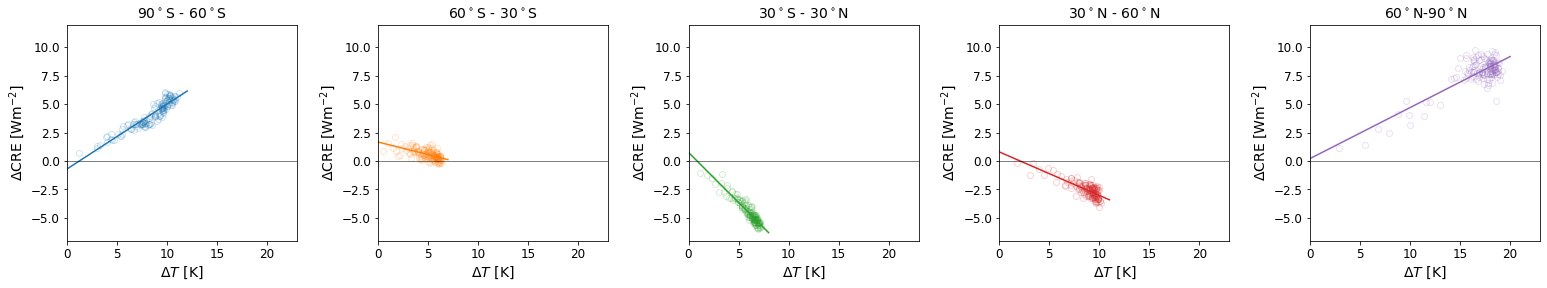

In [5]:
dif_CRE = np.zeros( ( 5, d))
dcre_dt_m = np.zeros( ( (5, 3, d)))
dcre_dt_m_c = np.zeros( ( (5, 3, d)))
dcre_dt_a = np.zeros( ( (5, 3, d)))
dcre_dt_a_c = np.zeros( ( ( 5, 3, d)))

fig = plt.figure( figsize = (22, 4) )
plt.subplots_adjust(left = 0.04, right = 0.97, bottom = 0.15, top = 0.9, hspace = 0.4, wspace = 0.35)

titles = ["90$^\circ$S - 60$^\circ$S", "60$^\circ$S - 30$^\circ$S", 
          "30$^\circ$S - 30$^\circ$N", "30$^\circ$N - 60$^\circ$N", "60$^\circ$N-90$^\circ$N"]
opts = ['rlut', 'rsut', 'rlutcs', 'rsutcs']

for k in range( 5 ):
    monthly_cre = np.zeros( ( (d, 3, dl * 12)))
    monthly_t = np.zeros( ( (d, 3, dl * 12)))

    for i in range( d ):
        histt = np.load("data/" + model[i] + "_historical_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        hist_t = histt["u"]

        abruptt = np.load("data/" + model[i] + "_abrupt-4xCO2_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        abrupt_t = abruptt["u"]
        pit = np.load("data/" + model[i] + "_PI_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        pi_t = pit["u"]
        d1, d2 = np.shape( hist_t)
        hist_c = np.zeros( (d1, d2))
        for j in range( 4 ):
            temp = np.load("data/" + model[i] + "_historical_" + opts[j] + 
                           "_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            if j< 2:
                hist_c += temp["u"][:]
            else:
                hist_c -= temp["u"][:]
                
            for h in range( 3 ):
                monthly_cre[i, h] = np.mean(hist_c[114 * 12 + h * dl * 12:131 * 12 + h * dl * 12], axis = 1) 
                monthly_t[i, h] = np.mean(hist_t[114 * 12 + h * dl * 12:131 * 12 + h * dl * 12], axis = 1) 
                monthly_t[i, h] = deasonalize(monthly_t[i, h])
                monthly_cre[i, h] = deasonalize(monthly_cre[i, h])
                dcre_dt_m[k, h, i] = lin_regression( monthly_t[i, h], monthly_cre[i, h])[0]
                dcre_dt_m_c[k, h, i] = lin_regression( monthly_t[i, h], monthly_cre[i, h])[4]*1.96

                annual_t = annual_mean(monthly_t[i, h])
                annual_cre = annual_mean(monthly_cre[i, h])
                annual_cre = ssi.detrend(annual_cre)
                annual_t = ssi.detrend(annual_t)
                dcre_dt_a[k, h, i] = lin_regression( annual_t, annual_cre)[0]
                dcre_dt_a_c[k, h, i] = lin_regression( annual_t, annual_cre)[4]* 1.96

        for j in range( 4 ):
            temp2 = np.load("data/" + model[i] + "_abrupt-4xCO2_" + opts[j] + 
                           "_" +  str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            d1, d2 = np.shape( temp2["u"])
            if j == 0:
                abrupt_cre = np.zeros( ( d1, d2))
            if j < 2:
                abrupt_cre += temp2["u"][:]
            else:
                abrupt_cre -= temp2["u"][:]
            temp3 = np.load("data/" + model[i] + "_PI_" + opts[j] + 
                           "_" +  str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            d1, d2 = np.shape( temp3["u"])
            if i == 5:
                d1 = 6000 #only take 500 years
            if j == 0:
                pi_cre = np.zeros( ( d1, d2))
            if j < 2:
                pi_cre += temp3["u"][:d1]
            else:
                pi_cre -= temp3["u"][:d1]
            del_cre = np.mean(abrupt_cre[:] - np.mean( pi_cre[:500 * 12]), axis = 1)
            del_t = np.mean(abrupt_t[:] - np.mean( pi_t[:500 * 12]), axis = 1)

            del_cre = annual_mean(del_cre)
            del_t = annual_mean( del_t)

            dif_CRE[k, i] = lin_regression(del_t[:], del_cre[:])[0]

        #Make Gregory plot for CanESM5
        if i == 0:
                plt.subplot(1, 5, k + 1)
                plt.title(titles[k], fontsize = 14)

                plt.plot( del_t, del_cre, 'o', color = "None", markeredgecolor = cs[2 * k], alpha = 0.2)
                plt.xlabel("$\Delta T$ [K]", fontsize = 14)
                plt.ylabel("$\Delta$CRE [Wm$^{-2}$]", fontsize = 14)

                slope, inter = lin_regression( del_t, del_cre)[:2]
                x = np.arange(0, np.max(del_t) + 1., 1.)
                plt.plot( x, inter + slope * x, color = cs[2*k])
                
                plt.ylim([-7., 12.])
                plt.xlim([0., 23.])

                plt.yticks(fontsize = 12)
                plt.xticks(fontsize = 12)
                
                plt.axhline(y = 0, color = 'k', linewidth = 0.5)
                
plt.savefig("CanESM5_regional_Gregory_plots.png")
plt.savefig("CanESM5_regional_Gregory_plots.pdf")

## get CERES/ERA5 data

In [6]:
ceres_mon = np.zeros( 5 )
ceres_an = np.zeros( 5 )

ceres_mon_se = np.zeros( 5 )
ceres_an_se = np.zeros( 5 )

lims1 = [90., 60., 30., -30., -60.]
lims2 = [60., 30., -30., -60., -90.]

for k in range( 5 ):
    obs_t = np.load("data/CERES-EBAF_tas_" + str(lims1[4 - k]) + "_" + str(lims2[4 - k]) + ".dat.npz")
    obs_cre = np.load("data/CERES-EBAF_net_cre_" + str(lim1[k]) + ".0_" + str(lim2[k]) + ".0.dat.npz")

    obs_t = np.mean(obs_t["u"][:], axis = 1)
    obs_cre = -np.mean(obs_cre["u"][:204], axis = 1)

    cannual_t = annual_mean(obs_t)
    cannual_cre = annual_mean(obs_cre)
    cannual_t = ssi.detrend(cannual_t)
    cannual_cre = ssi.detrend(cannual_cre)
    ceres_an[k] = lin_regression( cannual_t, cannual_cre)[0]
    ceres_an_se[k] = lin_regression( cannual_t, cannual_cre)[4] * 1.96
    
    obs_t = deasonalize(obs_t)
    obs_cre = deasonalize(obs_cre)
    ceres_mon[k] = lin_regression( obs_t, obs_cre)[0]
    ceres_mon_se[k] = lin_regression( obs_t, obs_cre)[4] * 1.96

## Check emergent constraints

In [7]:
corrs = np.zeros( ( ( 2, 5, 3)))
pval = np.zeros( ( ( 2, 5, 3)))

for i in range( 5):
    for j in range( 3):
        corrs[0, i, j] = np.corrcoef(-dcre_dt_m[i, j, :d], -dif_CRE[i, :d])[0, 1] ** 2
        corrs[1, i, j] = np.corrcoef(-dcre_dt_a[i, j, :d], -dif_CRE[i, :d])[0, 1] ** 2
        pval[0, i, j] = lin_regression(-dcre_dt_m[i, j, :d], -dif_CRE[i, :d])[3]
        pval[1, i, j] = lin_regression(-dcre_dt_a[i, j, :d], -dif_CRE[i, :d])[3]

#print correlations and p-values       
        
print(corrs[0])
print(corrs[1])

print(pval[0])
print(pval[1])

[[0.25261239 0.1930576  0.26558118]
 [0.077683   0.07737932 0.01409007]
 [0.37086031 0.60312531 0.46777954]
 [0.10802008 0.10875234 0.15816372]
 [0.04676144 0.0729772  0.01324211]]
[[1.18103851e-01 9.77210474e-02 1.89523281e-01]
 [7.82491924e-02 8.08376433e-02 4.30655995e-04]
 [2.79768596e-01 5.02656976e-01 4.29693977e-01]
 [3.83530013e-02 2.07270071e-01 1.10300917e-02]
 [3.27067939e-03 1.01243896e-01 4.61303904e-02]]
[[2.02274593e-02 4.62719957e-02 1.68057895e-02]
 [2.21157598e-01 2.22100222e-01 6.08322963e-01]
 [3.38949030e-03 3.47613856e-05 6.28833785e-04]
 [1.45759159e-01 1.44319519e-01 7.42018687e-02]
 [3.46458820e-01 2.36284272e-01 6.19399211e-01]]
[[1.27179162e-01 1.67685167e-01 4.85539700e-02]
 [2.19412030e-01 2.11624880e-01 9.28855619e-01]
 [1.36870409e-02 3.20489109e-04 1.25597989e-03]
 [3.94892914e-01 3.80932411e-02 6.50499976e-01]
 [8.05504086e-01 1.59817694e-01 3.49813148e-01]]


Plot example of last 17 years

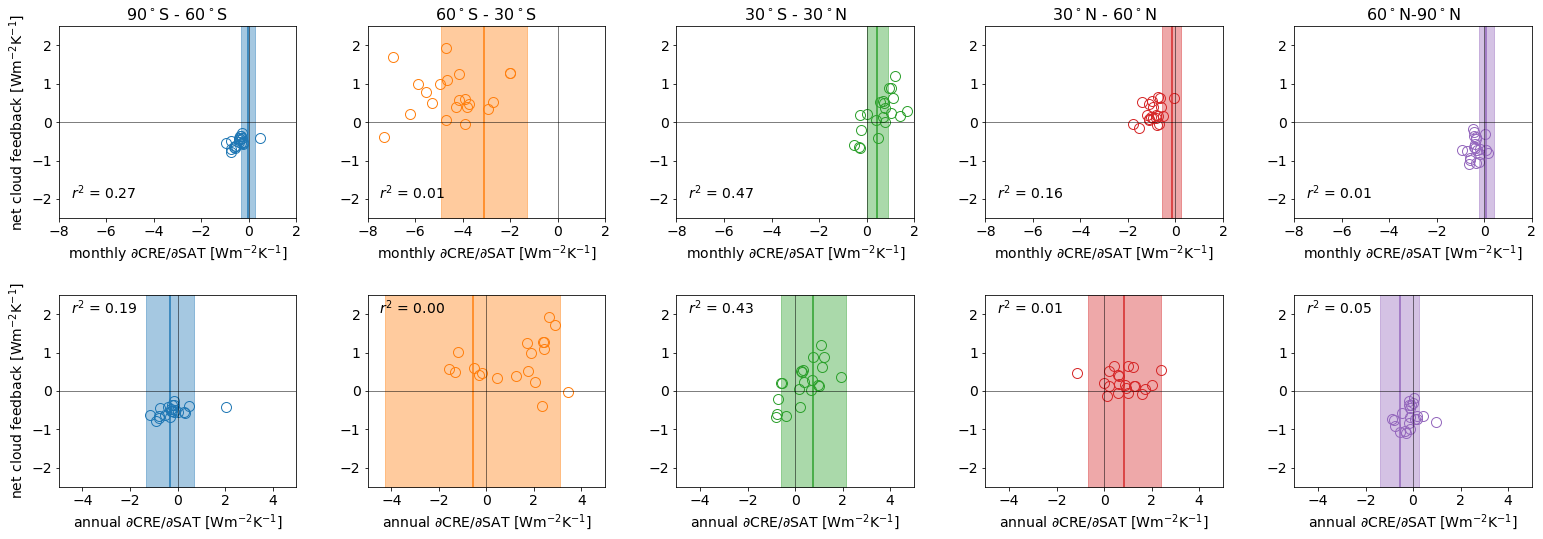

In [8]:
fig = plt.figure( figsize = (22, 8) )
plt.subplots_adjust(left = 0.04, right = 0.97, bottom = 0.15, top = 0.95, hspace = 0.4, wspace = 0.3)

for k in range( 5):
    ax = plt.subplot(2, 5, k + 1)
    plt.title(titles[k], fontsize = 16)
    plt.plot( -dcre_dt_m[k, 2, :d], -dif_CRE[k, :d], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-7.5, -2., "$r^2$ = %.2f" % np.corrcoef(-dcre_dt_m[k, 2, :d], -dif_CRE[k, :d])[0, 1] ** 2, fontsize = 14)
    plt.axvline(x = np.mean(ceres_mon[k]), color = cs[2*k])
    y = [-5., 3.]
    plt.fill_betweenx(y, x1 = ceres_mon[k] - ceres_mon_se[k], x2 = 
                      ceres_mon[k] + ceres_mon_se[k], color = cs[2*k], alpha = 0.4)
    
    plt.xlabel("monthly $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-8., 2.])

    plt.yticks([-2., -1., 0., 1., 2.], fontsize = 14)
    plt.xticks([-8., -6., -4., -2., 0., 2.], fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)
    
    ax = plt.subplot(2, 5, k + 6)
    plt.plot( -dcre_dt_a[k, 2, :d], -dif_CRE[k, :d], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-4.5, 2., "$r^2$ = %.2f" % np.corrcoef(-dcre_dt_a[k, 2, :d], -dif_CRE[k, :d])[0, 1] ** 2, fontsize = 14)
        
    plt.axvline(x = np.mean(ceres_an[k]), color = cs[2*k])
    plt.fill_betweenx(y, x1 = ceres_an[k] - ceres_an_se[k], x2 = ceres_an[k] + ceres_an_se[k], 
                      color = cs[2*k], alpha = 0.4)
    
    plt.xlabel("annual $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-5., 5.])

    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)

plt.savefig("EC_CMIP6.png")
plt.savefig("EC_CMIP6.pdf")


## Calculate posterior PDFs

In [9]:
#Prior PDFs
cre_90s = ss.gaussian_kde(-dif_CRE[0, :d],bw_method=bw)
cre_60s = ss.gaussian_kde(-dif_CRE[1, :d],bw_method=bw)
cre_30 = ss.gaussian_kde(-dif_CRE[2, :d],bw_method=bw)
cre_60n = ss.gaussian_kde(-dif_CRE[3, :d],bw_method=bw)
cre_90n = ss.gaussian_kde(-dif_CRE[4, :d],bw_method=bw)

In [10]:
#Calculate posterior PDFs using annual data
weights = np.zeros( ( (5, 3,d)))
ls = np.zeros( ( (5, 3, d)))
x = np.linspace(-4., 4., 100)

posterior_pdfs = np.zeros( ( (5, 3, lr)))

for k in range( 5):
    for h in range( 3 ):
        pdf_1 = 1. / (np.sqrt(2. * np.pi) * dcre_dt_a_c[k, h, :, np.newaxis] / 2.) * np.exp(-0.5 * ((x[np.newaxis, :] + dcre_dt_a[k, h, :, np.newaxis])/dcre_dt_a_c[k, h, :, np.newaxis] * 2.) ** 2)
        pdf_c = 1. / (np.sqrt(2. * np.pi) * ceres_an_se[k] / 2.) * np.exp(-0.5 * ((x[:] - ceres_an[k])/ceres_an_se[k] * 2.) ** 2)

        KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])
        for i in range( 100 ):
            for j in range( d ):
                if np.isposinf(KL_div[j, i]) == True:
                    KL_div[j, i] = 0.
        KL_div = np.trapz(KL_div, x, axis = 1)

        ls[k, h] = np.exp(-KL_div)

        weights[k, h] = ls[k, h] / sum(ls[k, h])
        
        posterior_pdf = ss.gaussian_kde(-dif_CRE[k, :d], weights = weights[k, h], bw_method=bw)
        
        posterior_pdfs[k, h] = posterior_pdf(range_1)

<ipython-input-10-3ec59db84957>:13: RuntimeWarning: divide by zero encountered in true_divide
  KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])
<ipython-input-10-3ec59db84957>:13: RuntimeWarning: overflow encountered in true_divide
  KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])


In [11]:
#Calculate posterior PDFs using monthly data
weights_m = np.zeros( ( (5, 3, d)))
ls_m = np.zeros( ( (5, 3, d)))
x = np.linspace(-4., 4., 100)

posterior_pdfs_m = np.zeros( ( (5, 3, lr)))

for k in range( 5):
    for h in range( 3 ):
        pdf_1 = 1. / (np.sqrt(2. * np.pi) * dcre_dt_m_c[k, h, :, np.newaxis] / 2.) * np.exp(-0.5 * ((x[np.newaxis, :] + dcre_dt_m[k, h, :, np.newaxis])/dcre_dt_m_c[k, h, :, np.newaxis] * 2.) ** 2)
        pdf_c = 1. / (np.sqrt(2. * np.pi) * ceres_mon_se[k] / 2.) * np.exp(-0.5 * ((x[:] - ceres_mon[k])/ceres_mon_se[k] * 2.) ** 2)

        KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])
        for i in range( 100 ):
            for j in range( d ):
                if np.isposinf(KL_div[j, i]) == True:
                    KL_div[j, i] = 0.
        KL_div = np.trapz(KL_div, x, axis = 1)

        ls_m[k, h] = np.exp(-KL_div)

        weights_m[k, h] = ls_m[k, h] / sum(ls_m[k, h])
        posterior_pdf = ss.gaussian_kde(-dif_CRE[k, :d], weights = weights_m[k, h], bw_method=bw)
        
        posterior_pdfs_m[k, h] = posterior_pdf(range_1)


<ipython-input-11-8565549bbab1>:13: RuntimeWarning: divide by zero encountered in true_divide
  KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])


Print weights for regions with strong relationships

In [12]:
model = ["CanESM5", "CESM2", "MRI-ESM2-0", "CNRM-ESM2-1", "IPSL-CM6A-LR",
         "UKESM1-0-LL", "CESM2-WACCM", "GFDL-CM4", "MIROC-ES2L", "HadGEM3-GC31-LL", "GISS-E2-1-H", 
         "GFDL-ESM4", "GISS-E2-1-G", "BCC-CSM2-MR", "BCC-ESM1", "INM-CM4-8", "MPI-ESM1-2-HR",
         "MIROC6", "CNRM-CM6-1", "NorESM2-LM", "FGOALS-f3-L"]

for i in range( d):
    print(model[i])
    print(weights_m[2, :, i] * 100.)
    print(weights[2, :, i] * 100.)
    print(weights_m[0, :, i] * 100.)

CanESM5
[12.20245999 13.89171072  0.60289668]
[10.66305785  9.45794058 10.02771058]
[0.00472732 1.50137865 0.60623805]
CESM2
[5.5357125  1.92673998 4.29123192]
[10.3370816   7.82831856  8.58697359]
[0.00170602 0.05433307 0.00446171]
MRI-ESM2-0
[10.00942992  3.51037816  2.22226396]
[6.9335573  1.71526971 1.30187278]
[0.00342209 0.07365363 0.88695061]
CNRM-ESM2-1
[15.92332288  7.60883976  4.25943864]
[0.83052562 4.66548503 3.67654039]
[1.67836776 2.12062473 0.01113567]
IPSL-CM6A-LR
[13.10202993  8.95879346 11.4679071 ]
[9.686054  9.8665102 4.2935583]
[1.26163558e-02 2.70169695e+01 5.57440737e-03]
UKESM1-0-LL
[3.41006015e-02 2.28890152e+00 6.15755975e-04]
[2.65104371 9.5463759  1.58036245]
[0.00086445 0.07610495 0.01852579]
CESM2-WACCM
[4.86020489 2.65231631 1.99383629]
[9.91010425 8.59882134 9.00945053]
[0.00100691 0.21558279 0.01314321]
GFDL-CM4
[ 0.87707064  5.92232527 12.67021144]
[7.57841455 8.82322429 9.26344721]
[6.82507583e-06 3.14967234e-05 4.14089684e-08]
MIROC-ES2L
[3.13479669e

# Repeat for CMIP5

## Load data (taken from GFDL servers)

In [13]:
acmip5_m = np.load("data/CMIP5_cres_m.dat")
acmip5_m_c = np.load("data/CMIP5_cres_m_c.dat")

acmip5_a = np.load("data/CMIP5_cres_a.dat")
acmip5_a_c = np.load("data/CMIP5_cres_a_c.dat")

acmip5_net_cre = np.load("data/CMIP5_net_cre.dat")


acmip5_m = np.swapaxes(acmip5_m, 0, 2)
acmip5_m_c = np.swapaxes(acmip5_m_c, 0, 2)
acmip5_a = np.swapaxes(acmip5_a, 0, 2)
acmip5_a_c = np.swapaxes(acmip5_a_c, 0, 2)
acmip5_net_cre = np.swapaxes(acmip5_net_cre, 0, 1)

#Take out MIROC-ESM-CHEM model
d2 = 22
cmip5_net_cre = np.zeros( (5, d2))
cmip5_net_cre[:, :15] = acmip5_net_cre[:, :15]
cmip5_net_cre[:, 15:] = acmip5_net_cre[:, 16:]


cmip5_m = np.zeros( ( (5, 3, d2 )))
cmip5_m[:, :, :15] = acmip5_m[:, :, :15]
cmip5_m[:, :, 15:] = acmip5_m[:, :, 16:]

cmip5_m_c = np.zeros( ( (5, 3, d2 )))
cmip5_m_c[:, :, :15] = acmip5_m_c[:, :, :15]
cmip5_m_c[:, :, 15:] = acmip5_m_c[:, :, 16:]

cmip5_a = np.zeros( ( (5, 3, d2 )))
cmip5_a[:, :, :15] = acmip5_a[:, :, :15]
cmip5_a[:, :, 15:] = acmip5_a[:, :, 16:]

cmip5_a_c = np.zeros( ( (5, 3, d2 )))
cmip5_a_c[:, :, :15] = acmip5_a_c[:, :, :15]
cmip5_a_c[:, :, 15:] = acmip5_a_c[:, :, 16:]


# Check emergent constraints

In [14]:
corrs = np.zeros( ( ( 2, 5, 3)))
pval = np.zeros( ( ( 2, 5, 3)))

for i in range( 5):
    for j in range( 3):
        corrs[0, i, j] = np.corrcoef(-cmip5_m[i, j, :], -cmip5_net_cre[i, :])[0, 1] ** 2
        corrs[1, i, j] = np.corrcoef(-cmip5_a[i, j, :], -cmip5_net_cre[i, :])[0, 1] ** 2
        pval[0, i, j] = lin_regression(-cmip5_m[i, j, :], -cmip5_net_cre[i, :])[3]
        pval[1, i, j] = lin_regression(-cmip5_a[i, j, :], -cmip5_net_cre[i, :])[3]

#print correlations and p-values
print(corrs[0])
print(corrs[1])
print(pval[0])
print(pval[1])


[[4.67611014e-04 5.23849832e-03 2.12397359e-04]
 [1.19223484e-03 1.35670028e-03 6.90083430e-03]
 [5.74794490e-01 3.54329797e-01 5.53291336e-01]
 [1.46482099e-01 2.63073824e-01 2.49941535e-01]
 [7.18565454e-02 1.24963883e-01 1.59121648e-02]]
[[3.12207601e-01 3.23574253e-02 1.87413445e-01]
 [5.08829249e-02 2.11169407e-02 3.04419659e-01]
 [6.56578981e-01 4.15305886e-01 4.09550909e-01]
 [2.24315873e-02 2.75389272e-01 1.65818206e-01]
 [4.75387822e-04 1.63891938e-02 2.02009116e-02]]
[[9.23903968e-01 7.48904402e-01 9.48675289e-01]
 [8.78756668e-01 8.70727804e-01 7.13222963e-01]
 [4.35114799e-05 3.47170439e-03 7.24399499e-05]
 [7.87439238e-02 1.46461374e-02 1.78220344e-02]
 [2.27758728e-01 1.06550480e-01 5.75908640e-01]]
[[6.87078064e-03 4.23110568e-01 4.41710947e-02]
 [3.12804150e-01 5.18766035e-01 7.76682205e-03]
 [4.85068711e-06 1.20649584e-03 1.33834123e-03]
 [5.05887906e-01 1.21576936e-02 5.99794072e-02]
 [9.23275591e-01 5.70196224e-01 5.28072705e-01]]


Plot example of last 17 years

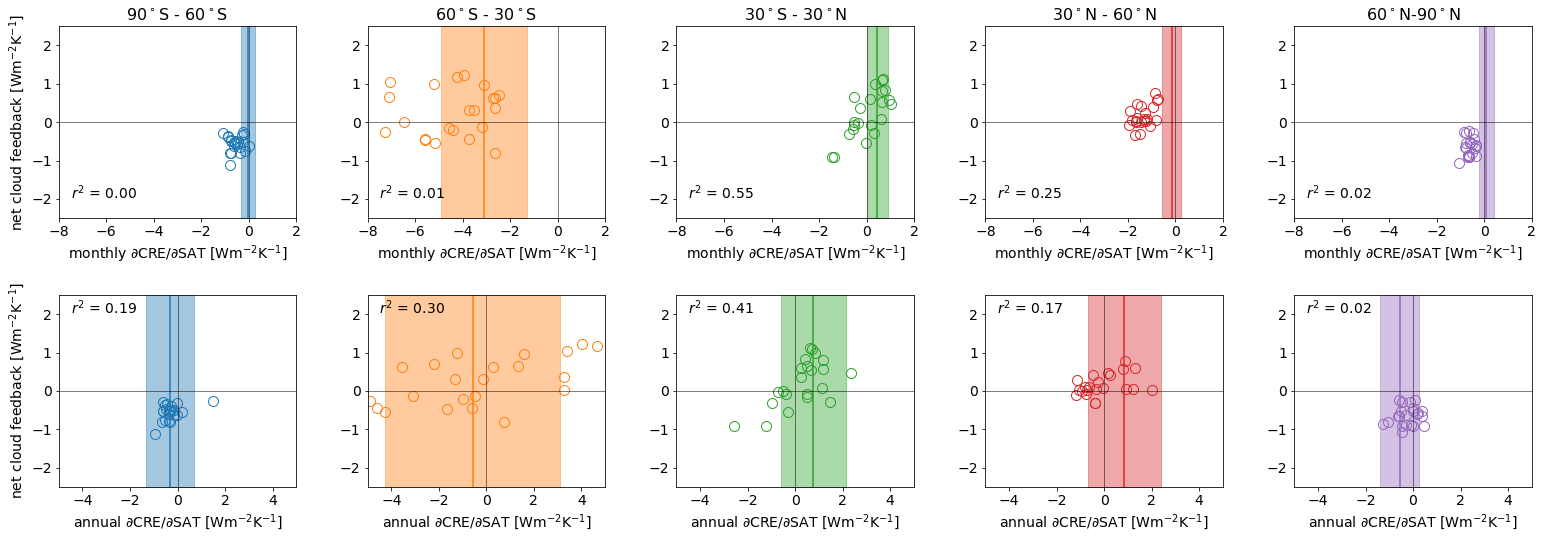

In [15]:
fig = plt.figure( figsize = (22, 8) )
plt.subplots_adjust(left = 0.04, right = 0.97, bottom = 0.15, top = 0.95, hspace = 0.4, wspace = 0.3)

for k in range( 5):
    ax = plt.subplot(2, 5, k + 1)
    plt.title(titles[k], fontsize = 16)
    plt.plot( -cmip5_m[k, 2, :d2], -cmip5_net_cre[k, :d2], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-7.5, -2., "$r^2$ = %.2f" % np.corrcoef(-cmip5_m[k, 2, :d2], -cmip5_net_cre[k, :d2])[0, 1] ** 2, fontsize = 14)
    plt.axvline(x = np.mean(ceres_mon[k]), color = cs[2*k])
    y = [-5., 3.]
    plt.fill_betweenx(y, x1 = ceres_mon[k] - ceres_mon_se[k], x2 = 
                      ceres_mon[k] + ceres_mon_se[k], color = cs[2*k], alpha = 0.4)
    
    plt.xlabel("monthly $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-8., 2.])

    plt.yticks([-2., -1., 0., 1., 2.], fontsize = 14)
    plt.xticks([-8., -6., -4., -2., 0., 2.], fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)
    
    ax = plt.subplot(2, 5, k + 6)
    plt.plot( -cmip5_a[k, 2, :d2], -cmip5_net_cre[k, :d2], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-4.5, 2., "$r^2$ = %.2f" % np.corrcoef(-cmip5_a[k, 2, :d2], -cmip5_net_cre[k, :d2])[0, 1] ** 2, fontsize = 14)
        
    plt.axvline(x = np.mean(ceres_an[k]), color = cs[2*k])
    plt.fill_betweenx(y, x1 = ceres_an[k] - ceres_an_se[k], x2 = ceres_an[k] + ceres_an_se[k], 
                      color = cs[2*k], alpha = 0.4)

    
    plt.xlabel("annual $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-5., 5.])

    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)

plt.savefig("EC_CMIP5.png")
plt.savefig("EC_CMIP5.pdf")


## Calculate posterior PDFs

In [16]:
#Prior PDFs
cre_90s2 = ss.gaussian_kde(-cmip5_net_cre[0, :d2],bw_method=bw)
cre_60s2 = ss.gaussian_kde(-cmip5_net_cre[1, :d2],bw_method=bw)
cre_302 = ss.gaussian_kde(-cmip5_net_cre[2, :d2],bw_method=bw)
cre_60n2 = ss.gaussian_kde(-cmip5_net_cre[3, :d2],bw_method=bw)
cre_90n2 = ss.gaussian_kde(-cmip5_net_cre[4, :d2],bw_method=bw)

In [17]:
#Calculate posterior PDFs with annual data
weights2 = np.zeros( ( (5, 3, d2)))
ls2 = np.zeros( ( (5, 3, d2)))
x = np.linspace(-4., 4., 100)

posterior_pdfs2 = np.zeros( ( (5, 3, lr)))
for k in range( 5):
    for h in range( 3 ):
        pdf_1 = 1. / (np.sqrt(2. * np.pi) * cmip5_a_c[k, h, :, np.newaxis] / 2.) * np.exp(-0.5 * ((x[np.newaxis, :] + cmip5_a[k, h, :, np.newaxis])/cmip5_a_c[k, h, :, np.newaxis] * 2.) ** 2)
        pdf_c = 1. / (np.sqrt(2. * np.pi) * ceres_an_se[k] / 2.) * np.exp(-0.5 * ((x[:] - ceres_an[k])/ceres_an_se[k] * 2.) ** 2)
        KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])
        for i in range( 100 ):
            for j in range( d2 ):
                if np.isposinf(KL_div[j, i]) == True:
                    KL_div[j, i] = 0.
        KL_div = np.trapz(KL_div, x, axis = 1)

        ls2[k, h] = np.exp(-KL_div)

        weights2[k, h] = ls2[k, h] / sum(ls2[k, h])
        
        posterior_pdf = ss.gaussian_kde(-cmip5_net_cre[k, :d2], weights = weights2[k, h], bw_method=bw)
        
        posterior_pdfs2[k, h] = posterior_pdf(range_1)

<ipython-input-17-fb2eba9094bd>:11: RuntimeWarning: divide by zero encountered in true_divide
  KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])
<ipython-input-17-fb2eba9094bd>:11: RuntimeWarning: overflow encountered in true_divide
  KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])


In [18]:
#Calculate posterior PDFs with monthly data
weights_m2 = np.zeros( ( (5, 3,d2)))
ls_m2 = np.zeros( ( (5, 3, d2)))
x = np.linspace(-4., 4., 100)

posterior_pdfs_m2 = np.zeros( ( (5, 3, lr)))

for k in range( 5):
    for h in range( 3 ):
        pdf_1 = 1. / (np.sqrt(2. * np.pi) * cmip5_m_c[k, h, :, np.newaxis] / 2.) * np.exp(-0.5 * ((x[np.newaxis, :] + cmip5_a[k, h, :, np.newaxis])/cmip5_m_c[k, h, :, np.newaxis] * 2.) ** 2)
        pdf_c = 1. / (np.sqrt(2. * np.pi) * ceres_mon_se[k] / 2.) * np.exp(-0.5 * ((x[:] - ceres_mon[k])/ceres_mon_se[k] * 2.) ** 2)

        KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])
        for i in range( 100 ):
            for j in range( d2 ):
                if np.isposinf(KL_div[j, i]) == True:
                    KL_div[j, i] = 0.
        KL_div = np.trapz(KL_div, x, axis = 1)

        ls_m2[k, h] = np.exp(-KL_div)

        weights_m2[k, h] = ls_m2[k, h] / sum(ls_m2[k, h])
        posterior_pdf = ss.gaussian_kde(-cmip5_net_cre[k, :d2], weights = weights_m2[k, h], bw_method=bw)
        
        posterior_pdfs_m2[k, h] = posterior_pdf(range_1)

<ipython-input-18-e15a0906ecef>:13: RuntimeWarning: divide by zero encountered in true_divide
  KL_div = pdf_c[np.newaxis, :] * np.log(pdf_c[np.newaxis, :] / pdf_1[:, :])


In [19]:
model2 = ["BNU-ESM", "CanESM2", "CNRM-CM5", "CSIRO-Mk3-6-0", 
          "GFDL-CM3", "GFDL-ESM2G", "GFDL-ESM2M", "GISS-E2-H", "GISS-E2-R", 
          "inmcm4", "IPSL-CM5A-LR", "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC5", 
          "MIROC-ESM", "HadGEM2-ES", "MPI-ESM-LR", "MPI-ESM-MR", 
          "MPI-ESM-P", "MRI-CGCM3", "CCSM4", "NorESM1-M"]

for i in range( d2  ):
    print(model2[i])
    print(weights_m2[2, :, i] * 100.)
    print(weights2[2, :, i] * 100.)
    print(weights_m2[3, :, i] * 100.)

BNU-ESM
[0.0302726  9.74717498 0.68976254]
[2.99794861 7.35570529 3.97514998]
[2.30111765e-04 8.55345704e-14 1.75357744e-12]
CanESM2
[1.84840842e-04 3.57135263e-11 8.29312666e+00]
[4.54423391 0.52119431 8.52984325]
[1.67512284e+01 3.77614955e+00 1.56156076e-02]
CNRM-CM5
[2.00414576e-02 3.50714455e-08 1.48291832e-06]
[0.27653038 0.14481645 0.02221095]
[1.39926412e+01 3.84357494e+00 6.04365186e-11]
CSIRO-Mk3-6-0
[ 3.69546391 11.63757507  3.78247886]
[10.34840918  6.5755479   8.85259002]
[1.31210000e-15 1.76897153e-26 1.28091846e+01]
GFDL-CM3
[19.38297206  0.26231602 12.06506718]
[9.10877332 7.20839573 7.53135295]
[8.21361454 0.0948188  1.37420131]
GFDL-ESM2G
[2.41624168e-04 1.54910549e-05 3.41333362e-06]
[0.98172837 0.19243199 0.74083089]
[1.30851276e+01 5.07528494e+00 8.00527987e-04]
GFDL-ESM2M
[1.19302594e-09 1.66086358e+01 7.06275188e-03]
[0.07347306 7.19636801 0.47395281]
[4.70871227e+00 8.65339067e-07 2.17135498e+01]
GISS-E2-H
[6.32813078e-15 1.70094023e-11 6.50780711e-11]
[3.086760

# Plot updated PDFs

Only plot the statistically significant relationships

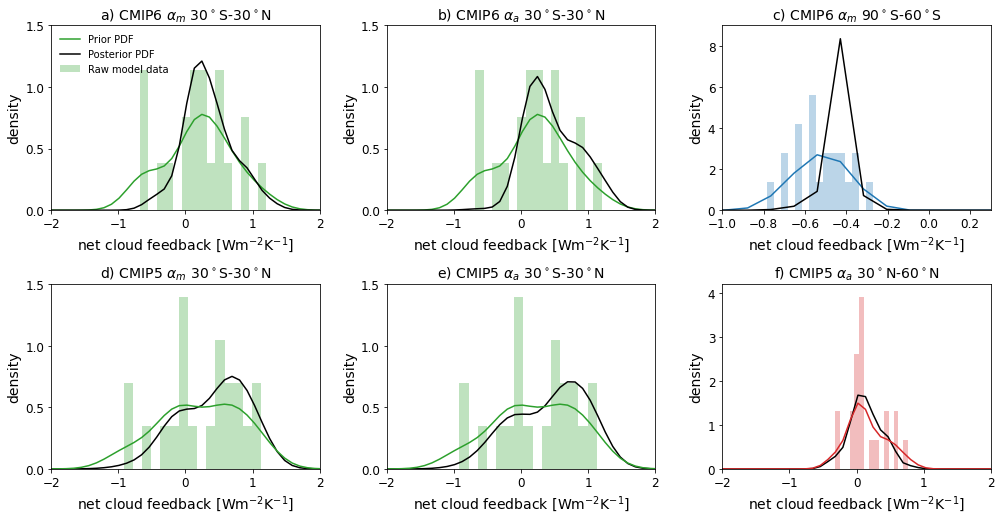

In [20]:
fig = plt.figure( figsize = (15, 8) )
plt.subplots_adjust(left = 0.1, right = 0.97, bottom = 0.15, top = 0.92, hspace = 0.4, wspace = 0.25)

plt.subplot(2, 3, 1)
plt.title("a) CMIP6 $\\alpha_m$ 30$^\circ$S-30$^\circ$N", fontsize = 14)
    
plt.hist( -dif_CRE[2, :d], 15, density = True, facecolor = cs[4], alpha = 0.3 )
plt.plot( range_1, cre_30(range_1), color = cs[4] )
plt.plot(range_1, np.mean(posterior_pdfs_m[2], axis = 0), 'k' )

plt.ylim([0., 1.5])
plt.xlim([-2., 2.])

plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.xticks([-2., -1., 0., 1., 2.], fontsize = 12)
plt.yticks([0., 0.5, 1., 1.5], fontsize = 12)
    
#plt.text( 2., 2.2, "Monthly", fontsize = 14, fontweight='bold')    
plt.legend(["Prior PDF", "Posterior PDF", "Raw model data"], frameon = False, loc = "upper left")

plt.subplot(2, 3, 4)
plt.title("d) CMIP5 $\\alpha_m$ 30$^\circ$S-30$^\circ$N", fontsize = 14)
    
plt.hist( -cmip5_net_cre[2, :d], 15, density = True, facecolor = cs[4], alpha = 0.3 )
plt.plot(range_1, np.mean(posterior_pdfs_m2[2], axis = 0), 'k' )
plt.plot( range_1, cre_302(range_1), color = cs[4] )

plt.ylim([0., 1.5])
plt.xlim([-2., 2.])

plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.xticks([-2., -1., 0., 1., 2.], fontsize = 12)
plt.yticks([0., 0.5, 1., 1.5], fontsize = 12)

plt.subplot(2, 3, 2)
plt.title("b) CMIP6 $\\alpha_a$ 30$^\circ$S-30$^\circ$N", fontsize = 14)
    
plt.hist( -dif_CRE[2, :d], 15, density = True, facecolor = cs[4], alpha = 0.3 )
plt.plot( range_1, cre_30(range_1), color = cs[4] )
plt.plot(range_1, np.mean(posterior_pdfs[2], axis = 0), 'k' )

plt.ylim([0., 1.5])
plt.xlim([-2., 2.])

plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.xticks([-2., -1., 0., 1., 2.], fontsize = 12)
plt.yticks([0., 0.5, 1., 1.5], fontsize = 12)
    
#plt.text( 1.8, 2.2, "Interannual", fontsize = 14, fontweight='bold')    
    
plt.subplot(2, 3, 5)
plt.title("e) CMIP5 $\\alpha_a$ 30$^\circ$S-30$^\circ$N", fontsize = 14)
    
plt.hist( -cmip5_net_cre[2, :d], 15, density = True, facecolor = cs[4], alpha = 0.3 )
plt.plot(range_1, np.mean(posterior_pdfs2[2], axis = 0), 'k' )
plt.plot( range_1, cre_302(range_1), color = cs[4] )

plt.ylim([0., 1.5])
plt.xlim([-2., 2.])

plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.xticks([-2., -1., 0., 1., 2.], fontsize = 12)
plt.yticks([0., 0.5, 1., 1.5], fontsize = 12)

plt.subplot(2, 3, 3)
plt.title("c) CMIP6 $\\alpha_m$ 90$^\circ$S-60$^\circ$S", fontsize = 14)
    
plt.hist( -dif_CRE[0, :d], 15, density = True, facecolor = cs[0], alpha = 0.3 )
plt.plot( range_1, cre_90s(range_1), color = cs[0] )
plt.plot(range_1, np.mean(posterior_pdfs_m[0], axis = 0), 'k' )

plt.ylim([0., 9.])
plt.xlim([-1., 0.3])

plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks([0., 2., 4., 6., 8.], fontsize = 12)
    
#plt.text( 1.8, 2.2, "Interannual", fontsize = 14, fontweight='bold')    
    
plt.subplot(2, 3, 6)
plt.title("f) CMIP5 $\\alpha_a$ 30$^\circ$N-60$^\circ$N", fontsize = 14)
    
plt.hist( -cmip5_net_cre[3, :d], 15, density = True, facecolor = cs[6], alpha = 0.3 )
plt.plot(range_1, np.mean(posterior_pdfs_m2[3], axis = 0), 'k' )
plt.plot( range_1, cre_60n2(range_1), color = cs[6] )

plt.ylim([0., 4.2])
plt.xlim([-1.5, 1.5])

plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.xticks([-2., -1., 0., 1., 2.], fontsize = 12)
plt.yticks([0., 1., 2., 3., 4.], fontsize = 12)

plt.savefig("EC_posterior_pdfs.png")
plt.savefig("EC_posterior_pdfs.pdf")

Look at percentiles

In [21]:
def calc_percentiles( pdf ):
    cdf = np.zeros( lr )
    for i in range( 1, lr):
        cdf[i] = np.trapz(pdf[:i])
    cdf /= max(cdf)
    
    j1 = np.where(cdf > 0.05)
    per_5 = np.min(range_1[j1])
    j2 = np.where(cdf > 0.95)
    per_95 = np.min(range_1[j2])
    
    return per_5, per_95

cm6_5, cm6_95 = calc_percentiles( cre_30(range_1))
cm5_5, cm5_95 = calc_percentiles( cre_302(range_1))

cm6_a5 = np.zeros( 3)
cm6_a95 = np.zeros( 3)
cm5_a5 = np.zeros( 3)
cm5_a95 = np.zeros( 3)

cm6_m5 = np.zeros(3)
cm6_m95 = np.zeros(3)
cm5_m5 = np.zeros(3)
cm5_m95 = np.zeros(3)
for i in range( 3):
    cm6_a5[i], cm6_a95[i] = calc_percentiles( posterior_pdfs[2, i])
    cm5_a5[i], cm5_a95[i] = calc_percentiles( posterior_pdfs2[2, i])

    cm6_m5[i], cm6_m95[i] = calc_percentiles( posterior_pdfs_m[2, i])
    cm5_m5[i], cm5_m95[i] = calc_percentiles( posterior_pdfs_m2[2, i])

cm6_a5 = np.mean(cm6_a5)
cm6_a95 = np.mean(cm6_a95)
cm5_a5 = np.mean(cm5_a5)
cm5_a95 = np.mean(cm5_a95)

cm6_m5 = np.mean(cm6_m5)
cm6_m95 = np.mean(cm6_m95)
cm5_m5 = np.mean(cm5_m5)
cm5_m95 = np.mean(cm5_m95)

print("CMIP6 raw:", cm6_5, cm6_95)
print("CMIP5 raw:", cm5_5, cm5_95)

print("CMIP6 post annual:", cm6_a5, cm6_a95)
print("CMIP5 post annual:", cm5_a5, cm5_a95)

print("CMIP6 post monthly:", cm6_m5, cm6_m95)
print("CMIP5 post monthly:", cm5_m5, cm5_m95)

CMIP6 raw: -0.653061224489796 1.2551020408163267
CMIP5 raw: -0.7653061224489797 1.3673469387755102
CMIP6 post annual: 0.05782312925170056 1.3673469387755102
CMIP5 post annual: -0.39115646258503406 1.4421768707482994
CMIP6 post monthly: -0.09183673469387754 1.1802721088435375
CMIP5 post monthly: -0.3163265306122449 1.4047619047619049


# Look at relationships with ECS

In [22]:
#CMIP6 ECS values
ECS = [5.6, 5.15, 3.13, 4.79, 4.56, 5.36, 4.68, 3.89, 2.66, 5.55, 3.12, 2.6, 2.71, 3.02, 3.26, 1.83,
       2.98, 2.6, 2.90, 2.56, 2.56]

cmip5_ECS = [4.04,3.70, 3.25, 4.09, 3.96, 2.43, 2.44, 2.31, 2.12, 2.08, 4.13, 4.11, 
             2.61, 2.72, 4.65, 4.60, 3.63, 3.45, 3.46, 2.61, 2.94, 2.80 ]

In [23]:
ECS_corrs = np.zeros( ( 2, 5))
ECS_p = np.zeros( ( 2, 5))

for i in range( 5):
    ECS_corrs[0, i] = np.corrcoef(dif_CRE[i], ECS)[0, 1] ** 2
    ECS_p[0, i] = lin_regression(dif_CRE[i], ECS)[3]
    
    ECS_corrs[1, i] = np.corrcoef(-cmip5_net_cre[i], cmip5_ECS)[0, 1] ** 2
    ECS_p[1, i] = lin_regression(-cmip5_net_cre[i], cmip5_ECS)[3]    

    print(ECS_corrs[0, i], ECS_p[0, i])
    print(ECS_corrs[1, i], ECS_p[1, i])
    
corrs_2K = np.zeros( 5 )
ps_2K = np.zeros( 5 )

for i in range(5):
    ndif_cre = np.ma.masked_where(np.array(ECS) < 2., dif_CRE[i])
    nECS = np.ma.masked_where(np.array(ECS) < 2., ECS)

    corrs_2K[i] = np.ma.corrcoef(ndif_cre, nECS)[0, 1] ** 2
    ps_2K[i] = lin_regression(ndif_cre, nECS)[3]

    print(corrs_2K[i], ps_2K[i])
    
corrs_4K = np.zeros( (2, 5 ) )
ps_4K = np.zeros( (2, 5 ) )
for i in range(5):
    ndif_cre = np.ma.masked_where(np.array(ECS) > 4., dif_CRE[i])
    nECS = np.ma.masked_where(np.array(ECS) > 4., ECS)

    corrs_4K[0, i] = np.ma.corrcoef(ndif_cre, nECS)[0, 1] ** 2
    ps_4K[0, i] = lin_regression(ndif_cre, nECS)[3]

    print(corrs_4K[0, i], ps_4K[0, i])
for i in range(5):
    ndif_cre = np.ma.masked_where(np.array(cmip5_ECS) > 4., cmip5_net_cre[i])
    nECS = np.ma.masked_where(np.array(cmip5_ECS) > 4., cmip5_ECS)

    corrs_4K[1, i] = np.ma.corrcoef(ndif_cre, nECS)[0, 1] ** 2
    ps_4K[1, i] = lin_regression(ndif_cre, nECS)[3]

    print(corrs_4K[1, i], ps_4K[1, i])    

0.1137193357472706 0.1349366887080633
0.07893573062511305 0.2053084386248643
0.2424373113318922 0.023359347773624094
0.0009692455002208027 0.890608439392894
0.5618398681041792 9.174896415529963e-05
0.5443295185985769 8.897803703726056e-05
0.1044730045616518 0.15294856471430449
0.055276319028999266 0.2922291559575581
0.16343386027836418 0.06911782657363436
0.07358663220131573 0.22202884653793528
0.11582925762816933 0.1349366887080633
0.1894806473421536 0.023359347773624094
0.5101988200223175 9.174896415529963e-05
0.08093166911322532 0.15294856471430449
0.29374543242399564 0.06911782657363436
0.053708021506817805 0.1349366887080633
0.3118582497668634 0.023359347773624094
0.14100943088826492 9.174896415529963e-05
0.13825230375807776 0.15294856471430449
0.03344801607510435 0.06911782657363436
0.09409265623144047 0.2053084386248643
0.06147094516544256 0.890608439392894
0.6390291962749169 8.897803703726056e-05
0.0025407305361017794 0.2922291559575581
0.047080601152237465 0.22202884653793528


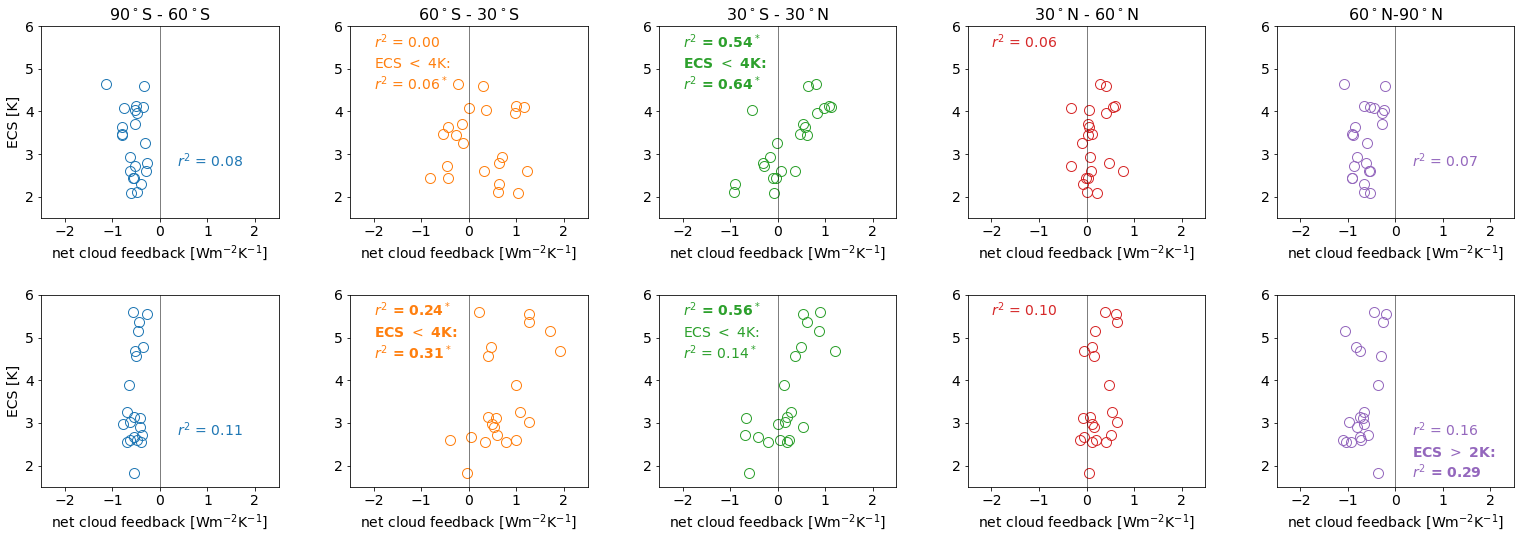

In [24]:
#Plot relationships
fig = plt.figure( figsize = (22, 8) )
plt.subplots_adjust(left = 0.04, right = 0.97, bottom = 0.15, top = 0.95, hspace = 0.4, wspace = 0.3)

for i in range( 5 ):
    plt.subplot(2, 5, i + 6)

    plt.plot( -dif_CRE[i], ECS, 'o', color = 'None', markeredgecolor = cs[2 * i], markersize = 10)
    if i == 1 or i == 2:
        plt.text(-2., 5.5, "$r^2$ = %.2f$^*$" % ECS_corrs[0, i], fontsize = 14, 
                 color = cs[2 * i], weight = "bold")
        if i == 2:
            plt.text(-2., 4.5, "ECS $<$ 4K:\n$r^2$ = %.2f$^*$" % corrs_4K[0, i], fontsize = 14, 
                 color = cs[2 * i])    
        else:
            plt.text(-2., 4.5, "ECS $<$ 4K:\n$r^2$ = %.2f$^*$" % corrs_4K[0, i], fontsize = 14, 
                 color = cs[2 * i], weight = "bold")   
    if i == 3:
        plt.text(-2., 5.5, "$r^2$ = %.2f" %  ECS_corrs[0, i], fontsize = 14, 
                 color = cs[2 * i])
    if i == 0 or i == 4:
        plt.text(0.35, 2.7, "$r^2$ = %.2f" %  ECS_corrs[0, i], fontsize = 14, 
                 color = cs[2 * i])
        if i == 4:
            plt.text(0.35, 1.7, "ECS $>$ 2K:\n$r^2$ = %.2f" %  corrs_2K[i], fontsize = 14, 
                 color = cs[2 * i], weight = "bold")    

    plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if i == 0:
        plt.ylabel("ECS [K]", fontsize = 14)

    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    
    plt.xlim([-2.5, 2.5])
    plt.ylim([1.5, 6.])
    plt.xticks([-2., -1., 0., 1., 2.], fontsize = 14)
    plt.yticks([2., 3., 4., 5., 6.], fontsize = 14)
    
for i in range( 5 ):
    plt.subplot(2, 5, i + 1)
    plt.title(titles[i], fontsize = 16)

    plt.plot( -cmip5_net_cre[i], cmip5_ECS, 'o', color = 'None', markeredgecolor = cs[2 * i], markersize = 10)
    if i == 1:
        plt.text(-2., 5.5, "$r^2$ = %.2f" %  ECS_corrs[1, i], fontsize = 14, 
                 color = cs[2 * i])
        plt.text(-2., 4.5, "ECS $<$ 4K:\n$r^2$ = %.2f$^*$" % corrs_4K[1, i], fontsize = 14, 
                 color = cs[2 * i]) 
    if i == 2:
        plt.text(-2., 5.5, "$r^2$ = %.2f$^*$" % ECS_corrs[1, i], fontsize = 14, 
                 color = cs[2 * i], weight = "bold")
        plt.text(-2., 4.5, "ECS $<$ 4K:\n$r^2$ = %.2f$^*$" % corrs_4K[1, i], fontsize = 14, 
                 color = cs[2 * i], weight = "bold") 
    if i == 3:
        plt.text(-2., 5.5, "$r^2$ = %.2f" % ECS_corrs[1, i], fontsize = 14, 
                 color = cs[2 * i])
    if i %4 == 0:
        plt.text(.35, 2.7, "$r^2$ = %.2f" % ECS_corrs[1, i], fontsize = 14, 
                 color = cs[2 * i])
        
    plt.xlabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if i == 0:
        plt.ylabel("ECS [K]", fontsize = 14)

    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    
    plt.xlim([-2.5, 2.5])
    plt.ylim([1.5, 6.])
    plt.xticks([-2., -1., 0., 1., 2.], fontsize = 14)
    plt.yticks([2., 3., 4., 5., 6.], fontsize = 14)
    
plt.savefig("EC_breakdown.png")
plt.savefig("EC_breakdown.pdf")


# Redo emergent constraints with 50 years of data

In [26]:
dcre_dt_m_50 = np.zeros( ( (5, d)))
dcre_dt_m_c_50 = np.zeros( ( (5, d)))
dcre_dt_a_50 = np.zeros( ( (5, d)))
dcre_dt_a_c_50 = np.zeros( ( ( 5, d)))

for k in range( 5 ):
    monthly_cre = np.zeros( ( d, 50 * 12))
    monthly_t = np.zeros( ( d, 50 * 12))

    for i in range( d ):
        histt = np.load("data/" + model[i] + "_historical_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        hist_t = histt["u"]

        d1, d2 = np.shape( hist_t)
        hist_c = np.zeros( (d1, d2))
        for j in range( 4 ):
            temp = np.load("data/" + model[i] + "_historical_" + opts[j] + 
                           "_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            if j< 2:
                hist_c += temp["u"][:]
            else:
                hist_c -= temp["u"][:]
                
            monthly_cre[i] = np.mean(hist_c[115 * 12:], axis = 1) 
            monthly_t[i] = np.mean(hist_t[115 * 12:], axis = 1) 
            monthly_t[i] = deasonalize(monthly_t[i])
            monthly_cre[i] = deasonalize(monthly_cre[i])
            dcre_dt_m_50[k, i] = lin_regression( monthly_t[i], monthly_cre[i])[0]
            dcre_dt_m_c_50[k, i] = lin_regression( monthly_t[i], monthly_cre[i])[4]*1.96

            annual_t = annual_mean(monthly_t[i])
            annual_cre = annual_mean(monthly_cre[i])
            annual_cre = ssi.detrend(annual_cre)
            annual_t = ssi.detrend(annual_t)
            dcre_dt_a_50[k, i] = lin_regression( annual_t, annual_cre)[0]
            dcre_dt_a_c_50[k, i] = lin_regression( annual_t, annual_cre)[4]* 1.96

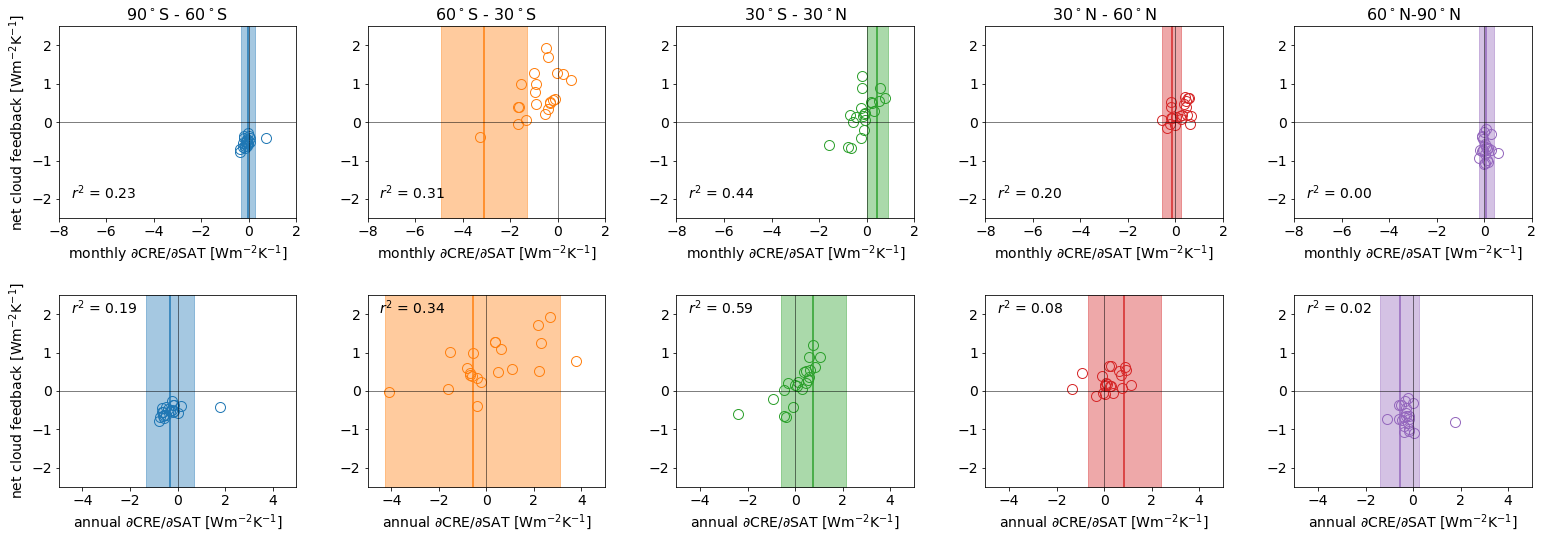

In [27]:
fig = plt.figure( figsize = (22, 8) )
plt.subplots_adjust(left = 0.04, right = 0.97, bottom = 0.15, top = 0.95, hspace = 0.4, wspace = 0.3)

for k in range( 5):
    ax = plt.subplot(2, 5, k + 1)
    plt.title(titles[k], fontsize = 16)
    plt.plot( -dcre_dt_m_50[k, :d], -dif_CRE[k, :d], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-7.5, -2., "$r^2$ = %.2f" % np.corrcoef(-dcre_dt_m_50[k, :d], -dif_CRE[k, :d])[0, 1] ** 2, fontsize = 14)
    plt.axvline(x = np.mean(ceres_mon[k]), color = cs[2*k])
    y = [-5., 3.]
    plt.fill_betweenx(y, x1 = ceres_mon[k] - ceres_mon_se[k], x2 = 
                      ceres_mon[k] + ceres_mon_se[k], color = cs[2*k], alpha = 0.4)
    
    plt.xlabel("monthly $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-8., 2.])

    plt.yticks([-2., -1., 0, 1., 2.], fontsize = 14)
    plt.xticks([-8., -6., -4., -2., 0., 2.], fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)
    
    ax = plt.subplot(2, 5, k + 6)
    plt.plot( -dcre_dt_a_50[k, :d], -dif_CRE[k, :d], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-4.5, 2., "$r^2$ = %.2f" % np.corrcoef(-dcre_dt_a_50[k, :d], -dif_CRE[k, :d])[0, 1] ** 2, fontsize = 14)
        
    plt.axvline(x = np.mean(ceres_an[k]), color = cs[2*k])
    plt.fill_betweenx(y, x1 = ceres_an[k] - ceres_an_se[k], x2 = ceres_an[k] + ceres_an_se[k], 
                      color = cs[2*k], alpha = 0.4)
    
    plt.xlabel("annual $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-5., 5.])

    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)

plt.savefig("EC_CMIP6_50.png")
plt.savefig("EC_CMIP6_50.pdf")


In [28]:
corrs = np.zeros( (2, 5))
pval = np.zeros( ( 2, 5))

for i in range( 5):
        corrs[0, i] = np.corrcoef(-dcre_dt_m_50[i, :d], -dif_CRE[i, :d])[0, 1] ** 2
        corrs[1, i] = np.corrcoef(-dcre_dt_a_50[i, :d], -dif_CRE[i, :d])[0, 1] ** 2
        pval[0, i] = lin_regression(-dcre_dt_m_50[i, :d], -dif_CRE[i, :d])[3]
        pval[1, i] = lin_regression(-dcre_dt_a_50[i, :d], -dif_CRE[i, :d])[3]

print(corrs[0])
print(corrs[1])

print(pval[0])
print(pval[1])

[0.23421848 0.31268491 0.43598954 0.19706957 0.00303547]
[0.19289074 0.33605565 0.59174305 0.08229467 0.01968972]
[0.02621716 0.00840458 0.00112351 0.04380671 0.81250384]
[4.63773724e-02 5.88061059e-03 4.58475608e-05 2.07376667e-01
 5.44072277e-01]


Repeat for CMIP5

In [29]:
cmip5_m_50 = np.load("data/CMIP5_cres_m_50.dat")
cmip5_m_c_50 = np.load("data/CMIP5_cres_m_c_50.dat")

cmip5_a_50 = np.load("data/CMIP5_cres_a_50.dat")
cmip5_a_c_50 = np.load("data/CMIP5_cres_a_c_50.dat")


cmip5_m_50 = np.swapaxes(cmip5_m_50, 0, 1)
cmip5_m_c_50 = np.swapaxes(cmip5_m_c_50, 0, 1)
cmip5_a_50 = np.swapaxes(cmip5_a_50, 0, 1)
cmip5_a_c_50 = np.swapaxes(cmip5_a_c_50, 0, 1)

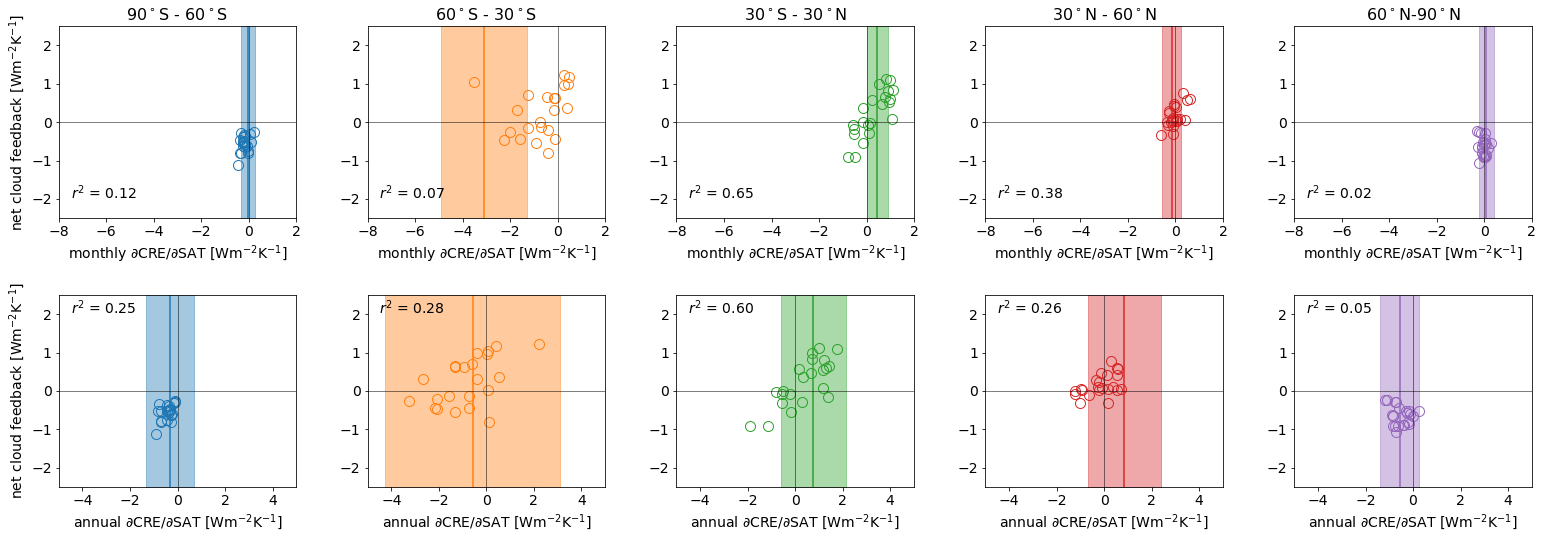

In [30]:
d2 = 22

fig = plt.figure( figsize = (22, 8) )
plt.subplots_adjust(left = 0.04, right = 0.97, bottom = 0.15, top = 0.95, hspace = 0.4, wspace = 0.3)

for k in range( 5):
    ax = plt.subplot(2, 5, k + 1)
    plt.title(titles[k], fontsize = 16)
    plt.plot( -cmip5_m_50[k, :d2], -cmip5_net_cre[k, :d2], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-7.5, -2., "$r^2$ = %.2f" % np.corrcoef(-cmip5_m_50[k, :d2], -cmip5_net_cre[k, :d2])[0, 1] ** 2, fontsize = 14)
    plt.axvline(x = np.mean(ceres_mon[k]), color = cs[2*k])
    y = [-5., 3.]
    plt.fill_betweenx(y, x1 = ceres_mon[k] - ceres_mon_se[k], x2 = 
                      ceres_mon[k] + ceres_mon_se[k], color = cs[2*k], alpha = 0.4)
    
    plt.xlabel("monthly $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-8., 2.])

    plt.yticks([-2., -1., 0., 1., 2.], fontsize = 14)
    plt.xticks([-8., -6., -4., -2., 0., 2.], fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)
    
    ax = plt.subplot(2, 5, k + 6)
    plt.plot( -cmip5_a_50[k, :d2], -cmip5_net_cre[k, :d2], 'o', color = 'None', markeredgecolor = cs[2 * k], markersize = 10)
    plt.text(-4.5, 2., "$r^2$ = %.2f" % np.corrcoef(-cmip5_a_50[k, :d2], -cmip5_net_cre[k, :d2])[0, 1] ** 2, fontsize = 14)
        
    plt.axvline(x = np.mean(ceres_an[k]), color = cs[2*k])
    plt.fill_betweenx(y, x1 = ceres_an[k] - ceres_an_se[k], x2 = ceres_an[k] + ceres_an_se[k], 
                      color = cs[2*k], alpha = 0.4)

    
    plt.xlabel("annual $\partial$CRE/$\partial$SAT [Wm$^{-2}$K$^{-1}$]", fontsize = 14)
    if k == 0:
        plt.ylabel("net cloud feedback [Wm$^{-2}$K$^{-1}$]", fontsize = 14)

    plt.ylim([-2.5, 2.5])
    plt.xlim([-5., 5.])

    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    
    plt.axvline(x = 0, color = 'k', linewidth = 0.5)
    plt.axhline(y = 0, color = 'k', linewidth = 0.5)

plt.savefig("EC_CMIP5_50.png")
plt.savefig("EC_CMIP5_50.pdf")


In [31]:
corrs = np.zeros( (2, 5))
pval = np.zeros( ( 2, 5))

for i in range( 5):
        corrs[0, i] = np.corrcoef(-cmip5_m_50[i, :d2], -cmip5_net_cre[i, :d2])[0, 1] ** 2
        corrs[1, i] = np.corrcoef(-cmip5_a_50[i, :d2], -cmip5_net_cre[i, :d2])[0, 1] ** 2
        pval[0, i] = lin_regression(-cmip5_m_50[i, :d2], -cmip5_net_cre[i, :d2])[3]
        pval[1, i] = lin_regression(-cmip5_a_50[i, :d2], -cmip5_net_cre[i, :d2])[3]

print(corrs[0])
print(corrs[1])

print(pval[0])
print(pval[1])

[0.12124452 0.074127   0.65208217 0.37677573 0.02466642]
[0.24637891 0.27984066 0.59599042 0.26493295 0.04603746]
[1.12277383e-01 2.20272539e-01 5.54122806e-06 2.37710806e-03
 4.85173372e-01]
[1.87893620e-02 1.13601395e-02 2.56886428e-05 1.42421219e-02
 3.37620418e-01]


# Joint correlations

In [35]:
joint_var_17 = np.zeros( ( ( ( 2, 5, 3, d + d2)) ) )
joint_var_50 = np.zeros( ( ( 2,  5, d + d2)) )

joint_var_17[0, :, :, :d] = dcre_dt_m[:, :, :]
joint_var_17[1, :, :, :d] = dcre_dt_a[:, :, :]
joint_var_17[0, :, :, d:] = cmip5_m[:, :, :]
joint_var_17[1, :, :, d:] = cmip5_a[:, :, :]

joint_var_50[0, :, :d] = dcre_dt_m_50[:, :]
joint_var_50[1, :, :d] = dcre_dt_a_50[:, :]
joint_var_50[0, :, d:] = cmip5_m_50[:, :]
joint_var_50[1, :, d:] = cmip5_a_50[:, :]


joint_cre = np.zeros( ( 5, d + d2))
joint_cre[:, :d] = dif_CRE[:, :]
joint_cre[:, d:] = cmip5_net_cre[:, :]

ValueError: could not broadcast input array from shape (5,23) into shape (5,22)

In [36]:
for i in range( 5 ):
    for j in range( 2):
        for k in range( 3):
            print(i, j, k)
            print(np.corrcoef(joint_var_17[j, i, k], joint_cre[i])[0, 1] ** 2)
            print(lin_regression(joint_var_17[j, i, k], joint_cre[i])[3])


0 0 0
0.045424453818720054
0.16999160108567804
0 0 1
0.019350848422422785
0.3736567423554328
0 0 2
0.043630468296220595
0.17887309282259087
0 1 0
0.14419788209958098
0.01201948861535824
0 1 1
0.047430637250507376
0.16063495259562693
0 1 2
0.1647116298885582
0.006929998668121047
1 0 0
0.013227590951027072
0.46270613704411034
1 0 1
0.0038632913003886276
0.692139609211494
1 0 2
0.0072848790997303995
0.5863110249170111
1 1 0
0.1448002853577548
0.011827660290468082
1 1 1
0.010052093628669904
0.5223731983811326
1 1 2
0.16365285457042508
0.007130900936482668
2 0 0
0.48123123275290985
2.5025461865686455e-07
2 0 1
0.39542109109216883
6.3073013779298744e-06
2 0 2
0.43408855059647655
1.5599992792899027e-06
2 1 0
0.49605789440143516
1.362064273456421e-07
2 1 1
0.4227865342795167
2.3678850624963347e-06
2 1 2
0.4129334824456654
3.3859150987679438e-06
3 0 0
0.15022101014669226
0.010231416391385539
3 0 1
0.2163017377027202
0.0016759987429790753
3 0 2
0.21905455095046658
0.00155107681296688
3 1 0
0.000

In [37]:
for i in range( 5 ):
    for j in range( 2):
            print(i, j)
            print(np.corrcoef(joint_var_50[j, i], joint_cre[i])[0, 1] ** 2)
            print(lin_regression(joint_var_50[j, i], joint_cre[i])[3])


0 0
0.04561540539281159
0.16907552566692563
0 1
0.029513499511722614
0.2706558243689171
1 0
0.0063865344531704536
0.6104600107329162
1 1
0.15384579896625777
0.009284054783433872
2 0
0.17049921297323234
0.005925743736963344
2 1
0.23673131855579185
0.0009386921766756479
3 0
0.10544619181944452
0.03362275990413577
3 1
0.047768696046002916
0.15911500783165275
4 0
0.002992067658935702
0.7275533277386431
4 1
0.005567568122561703
0.634404536873318
